We finetune ResNet152 and VGG models on dalle-recognition-dataset (https://www.kaggle.com/datasets/gauravduttakiit/dalle-recognition-dataset/) to classify AI-Generated vs. human drawn art.

Code references the following sources:
https://jovian.ml/ankitvashisht12/dog-breed-classifier-final#C32
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
https://github.com/munniomer/pytorch-tutorials/blob/master/beginner_source/finetuning_torchvision_models_tutorial.py

In [ ]:
# Import all necessary libraries
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict

import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# Access our data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
dalle_dataset = ImageFolder('drive/MyDrive/TMI AI Art Detection Team Drive/Datasets/Dalle_Dataset', transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()]))

In [ ]:
a, b = dalle_dataset[1]

dalle_dataset.classes

['Generated', 'Real']

# Finetune pretrained image classification models

Split into batches

In [ ]:
train_size = round(len(dalle_dataset) * 0.7)
val_size = (len(dalle_dataset) - train_size) // 2
test_size = (len(dalle_dataset) - train_size) // 2 + 1

train_data, val_data, test_data = random_split(dalle_dataset,[train_size, val_size, test_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")
print(f"Length of Test Data : {len(test_data)}")

#load the train and validation into batches.
batch_size = 128
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 2, pin_memory = True)
test_dl = DataLoader(test_data, batch_size, num_workers = 2, pin_memory = True)

#Move dataloaders to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Length of Train Data : 3525
Length of Validation Data : 755
Length of Test Data : 756


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Resnet152

In [ ]:
resnet152_model = torchvision.models.resnet152(pretrained=True)

for param in resnet152_model.parameters():
    param.requires_grad = False
resnet152_model.fc = nn.Linear(2048, 2) #set number of output classes to 2

In [ ]:
#Hyperparameters for resnet152
resnet152_model.to(device)
epoch = 20
loss_function = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.SGD(resnet152_model.parameters(), lr)

In [ ]:
def train(train_loader, val_loader, model, loss_function, optimizer, epoch, model_name):
  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []

  for epoch_num in range(epoch):
    model.train()
    train_loss_epoch = []
    train_acc_epoch = []
    val_loss_epoch = []
    val_acc_epoch = []

    #train
    for i, batch in enumerate(train_loader):
      img, label = batch
      img, label = img.to(device), label.to(device)
      output = model(img)
      loss = loss_function(output, label)
      acc = accuracy(output, label)
      train_loss_epoch.append(loss.item()/batch_size)
      train_acc_epoch.append(acc)

      # Backpropogation
      loss.backward()
      #Update weights
      #output = output.unsqueeze(1).float() #match dimensions
      optimizer.step()
      #Zeros the gradients (to make sure that you are not doing backpropogation with previous gradients)
      optimizer.zero_grad()

    # Validate
    model.eval()
    for j, batch in enumerate(val_loader):
      img, label = batch
      img, label = img.to(device), label.to(device)
      output = model(img)
      loss = loss_function(output, label)
      acc = accuracy(output, label)
      val_loss_epoch.append(loss.item()/batch_size)
      val_acc_epoch.append(acc)

    train_loss.append(sum(train_loss_epoch)/len(train_loss_epoch))
    train_acc.append(sum(train_acc_epoch)/len(train_acc_epoch))
    val_loss.append(sum(val_loss_epoch)/len(val_loss_epoch))
    val_acc.append(sum(val_acc_epoch)/len(val_acc_epoch))

    #save best epoch if less than minimum validation loss
    if val_loss[-1] <= min(val_loss):
      print("Saving model")
      path = 'drive/MyDrive/TMI AI Art Detection Team Drive/Datasets'
      save_model = f'{model_name}.pth'
      model_path = os.path.join(path, save_model)
      torch.save(model.state_dict(), model_path)

    print(f"Epoch {epoch_num}: Train Loss {train_loss[epoch_num]}, Train Acc {train_acc[epoch_num]}, Val Loss {val_loss[epoch_num]}, Val Acc {val_acc[epoch_num]}")
  return train_loss, train_acc, val_loss, val_acc


In [ ]:
train_loss, train_acc, val_loss, val_acc = train(train_dl, val_dl, resnet152_model, loss_function, optimizer, epoch, "resnet152")

Saving model
Epoch 0: Train Loss 0.004663367240157511, Train Acc 0.6659873127937317, Val Loss 0.003875022016776105, Val Acc 0.7872735857963562
Epoch 1: Train Loss 0.0038547170614557607, Train Acc 0.7687023282051086, Val Loss 0.003954585369986792, Val Acc 0.736616849899292
Saving model
Epoch 2: Train Loss 0.003418526628852955, Train Acc 0.8090425729751587, Val Loss 0.003455153627631565, Val Acc 0.792187511920929
Saving model
Epoch 3: Train Loss 0.003267093578220478, Train Acc 0.8177689909934998, Val Loss 0.003200921113602817, Val Acc 0.8237318992614746
Epoch 4: Train Loss 0.0031508571285355303, Train Acc 0.8263376951217651, Val Loss 0.0036622108115504184, Val Acc 0.7762680649757385
Saving model
Epoch 5: Train Loss 0.0030058210249990225, Train Acc 0.8367785811424255, Val Loss 0.003046102278555433, Val Acc 0.8276381492614746
Saving model
Epoch 6: Train Loss 0.002918805893776672, Train Acc 0.8383354544639587, Val Loss 0.002882427225510279, Val Acc 0.8448596000671387
Epoch 7: Train Loss 0.0

In [ ]:
def test(test_loader, model, loss_function, optimizer):
    test_loss = []
    test_acc = []
    # Test
    model.eval()
    for j, batch in enumerate(test_loader):
      img, label = batch
      img, label = img.to(device), label.to(device)
      output = model(img)
      loss = loss_function(output, label)
      acc = accuracy(output, label)
      test_loss.append(loss.item()/batch_size)
      test_acc.append(acc)

    loss_final = (sum(test_loss)/len(test_loss))
    acc_final = (sum(test_acc)/len(test_acc))

    print(f"Test Loss {loss_final}, Test Acc {acc_final}")

In [ ]:
test(test_dl, resnet152_model, loss_function, optimizer)

Test Loss 0.0028179737273603678, Test Acc 0.8400233387947083


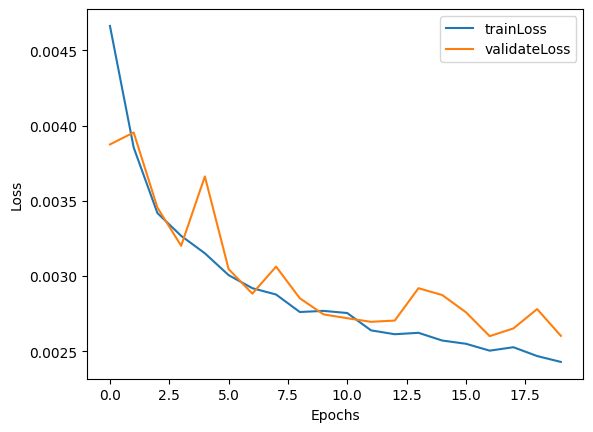

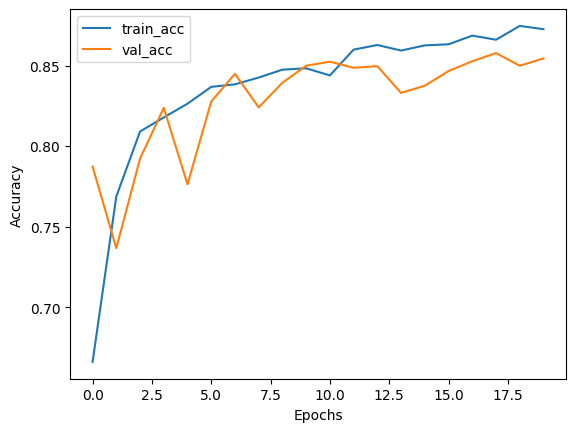

In [ ]:
#Plot the loss and values in separate plots
plt.figure()
plt.plot(train_loss, label='trainLoss')
plt.plot(val_loss,label='validateLoss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc,label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

VGG

In [ ]:
vgg_model = torchvision.models.vgg16(pretrained=True)

for param in vgg_model.parameters():
    param.requires_grad = False

print(vgg_model)
vgg_model.classifier[-1] = nn.Linear(4096, 2)

In [ ]:
#Hyperparameters for resnet152
vgg_model.to(device)
epoch = 20
loss_function = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.SGD(vgg_model.parameters(), lr)

In [ ]:
train_loss, train_acc, val_loss, val_acc = train(train_dl, val_dl, vgg_model, loss_function, optimizer, epoch, "vgg")

Saving model
Epoch 0: Train Loss 0.004765306981945676, Train Acc 0.6680172681808472, Val Loss 0.004220013118659456, Val Acc 0.7470335364341736
Saving model
Epoch 1: Train Loss 0.00422670875143792, Train Acc 0.7304404377937317, Val Loss 0.0040600256761536, Val Acc 0.7523890137672424
Saving model
Epoch 2: Train Loss 0.003980769044054406, Train Acc 0.758698046207428, Val Loss 0.003851265413686633, Val Acc 0.7771286368370056
Saving model
Epoch 3: Train Loss 0.0038576851948164403, Train Acc 0.7633605003356934, Val Loss 0.003722045376586417, Val Acc 0.796093761920929
Saving model
Epoch 4: Train Loss 0.0037312257502760205, Train Acc 0.7798225283622742, Val Loss 0.0036822984693571925, Val Acc 0.7839334011077881
Saving model
Epoch 5: Train Loss 0.003658931652483131, Train Acc 0.7838096618652344, Val Loss 0.0035747685081635914, Val Acc 0.8049139380455017
Saving model
Epoch 6: Train Loss 0.003611349658707955, Train Acc 0.7879140973091125, Val Loss 0.0035208524204790592, Val Acc 0.7972486615180969

In [ ]:
test(test_dl, vgg_model, loss_function, optimizer)

Test Loss 0.0033249170907462635, Test Acc 0.8047323822975159


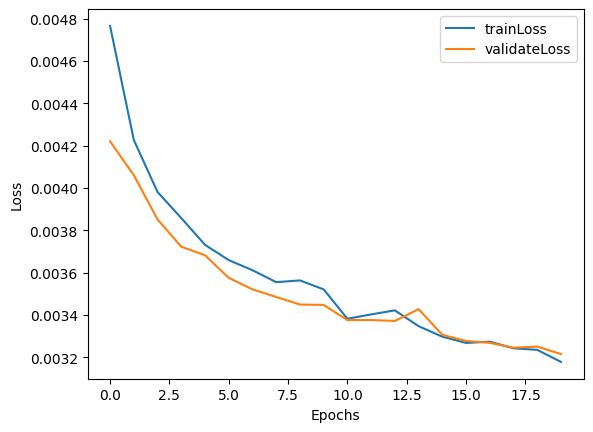

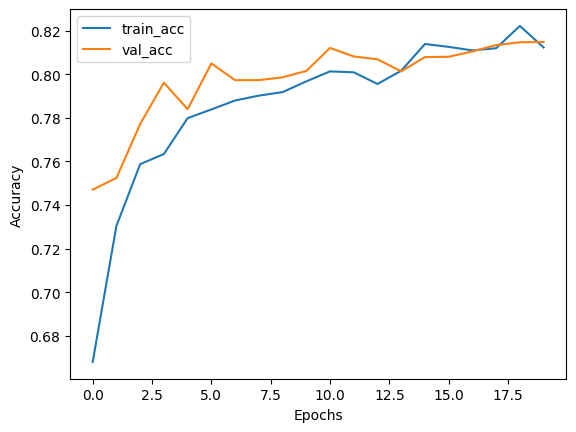

In [ ]:
#Plot the loss and values in separate plots
plt.figure()
plt.plot(train_loss, label='trainLoss')
plt.plot(val_loss,label='validateLoss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc,label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

ResNet152 train last two layers

In [ ]:
resnet152_model_layer4 = torchvision.models.resnet152(pretrained=True)

for param in resnet152_model_layer4.parameters():
    param.requires_grad = False

resnet152_model_layer4.fc = nn.Linear(2048, 2) #set number of output classes to 2
for param in resnet152_model_layer4.layer4.parameters():  # Last layer
    param.requires_grad = True

for name, param in resnet152_model_layer4.named_parameters():
    print(name,param.requires_grad)

conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.0.conv3.weight False
layer1.0.bn3.weight False
layer1.0.bn3.bias False
layer1.0.downsample.0.weight False
layer1.0.downsample.1.weight False
layer1.0.downsample.1.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.1.conv3.weight False
layer1.1.bn3.weight False
layer1.1.bn3.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer1.2.conv3.weight False
layer1.2.bn3.weight False
layer1.2.bn3.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2

In [ ]:
#Hyperparameters for resnet152
resnet152_model_layer4.to(device)
epoch = 100
loss_function = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.SGD(resnet152_model_layer4.parameters(), lr)

In [ ]:
train_loss, train_acc, val_loss, val_acc = train(train_dl, val_dl, resnet152_model_layer4, loss_function, optimizer, epoch, "resnet152_train_layer4")

Saving model
Epoch 0: Train Loss 0.004494531778618693, Train Acc 0.6851546168327332, Val Loss 0.003782381225998203, Val Acc 0.7739583849906921
Saving model
Epoch 1: Train Loss 0.003349930322396436, Train Acc 0.8159371614456177, Val Loss 0.003376301028765738, Val Acc 0.8099977374076843
Saving model
Epoch 2: Train Loss 0.0029496336438959198, Train Acc 0.8350276350975037, Val Loss 0.002755580780406793, Val Acc 0.8539741635322571
Saving model
Epoch 3: Train Loss 0.0024248219643985586, Train Acc 0.8769571185112, Val Loss 0.0026190183513487377, Val Acc 0.8622282147407532
Saving model
Epoch 4: Train Loss 0.0021357815255344447, Train Acc 0.8927398324012756, Val Loss 0.002360373910050839, Val Acc 0.8806045651435852
Saving model
Epoch 5: Train Loss 0.0018398652693057166, Train Acc 0.9135449528694153, Val Loss 0.0022319663936893144, Val Acc 0.8874094486236572
Saving model
Epoch 6: Train Loss 0.0015814038883295975, Train Acc 0.9266223311424255, Val Loss 0.0021424913623680673, Val Acc 0.89001363515

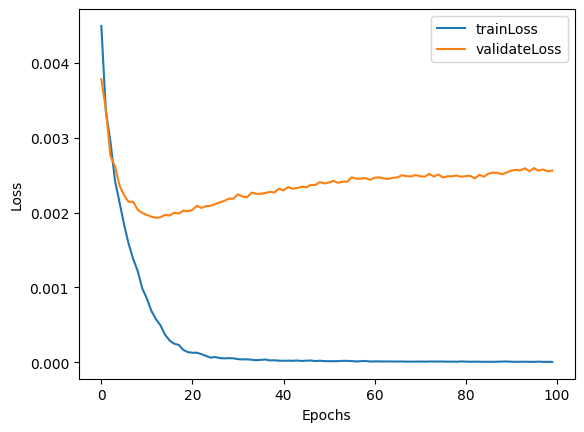

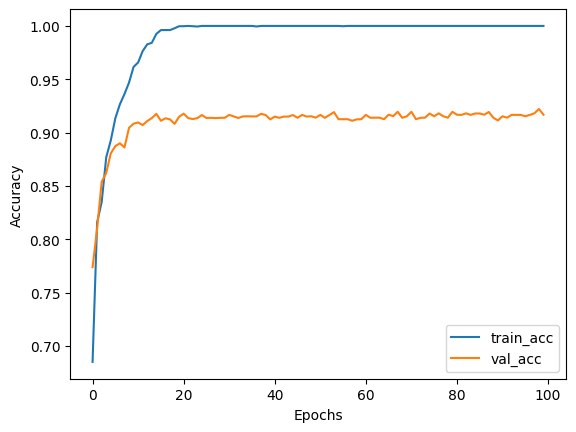

In [ ]:
#Plot the loss and values in separate plots
plt.figure()
plt.plot(train_loss, label='trainLoss')
plt.plot(val_loss,label='validateLoss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure()
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc,label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()